In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
sys.path.append("../core/")
from pupil_masks import *
from optim_functions import *
import os



ImportError: cannot import name 'funcsigs'

In [2]:
%matplotlib notebook

In [3]:

total = nHexesInsideRing(7)
print(total)
segments = range(7, total)
ap2 = poppy.MultiHexagonAperture(name="LUVOIR", rings=6, gap=0.05, center=False, flattoflat=1.15, segmentlist=segments)
ap2.display(npix=1024, colorbar_orientation='vertical')
#ap2.toFITS(outname="LUVOIRapertureLyotStop.fits", what='amplitude', npix=512)

NameError: name 'nHexesInsideRing' is not defined

ap2.toFITS(outname="LUVOIRaperture.fits", what='amplitude', npix=512)

8


/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:44: RuntimeWarning: overflow encountered in power
  pupil = np.exp(-np.sqrt((X/a)**2 + (Y/b)**2)**1000)


<IPython.core.display.Javascript object>


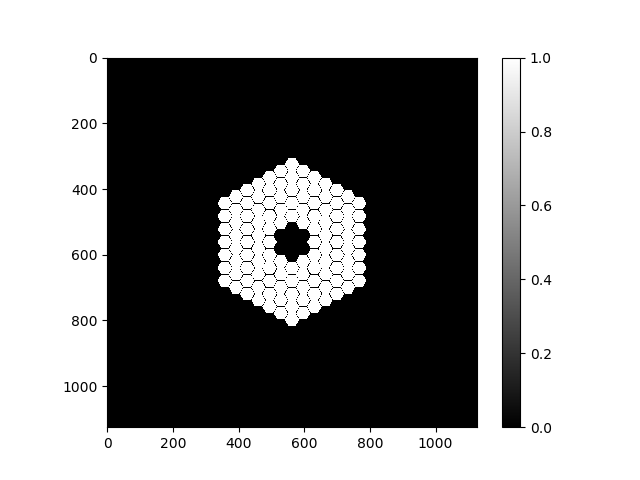

In [4]:
N = 4096
x = np.arange(-N/2, N/2)
y = np.arange(-N/2, N/2)
X, Y = np.meshgrid(x,y)

RHO, THETA = cart2pol(X,Y) 


apRad= 256
lD = int(N/(2*apRad))
print(lD)
EP = fits.getdata("LUVOIRoptimization/LUVOIRaperture.fits")
EP = np.lib.pad(EP, (int(N/2)-apRad, int(N/2)-apRad), 'constant', constant_values=(0,0))
LS = make_elliptical_pupil(1024, 1.0, apRad)
LS = np.lib.pad(LS, (1536, 1536), 'constant', constant_values=(0,0))

FP = myfft2(EP)
PSF = np.abs(FP)**2
#LS = EP

plot_im_LP(EP, apRad, 1.2)

<IPython.core.display.Javascript object>


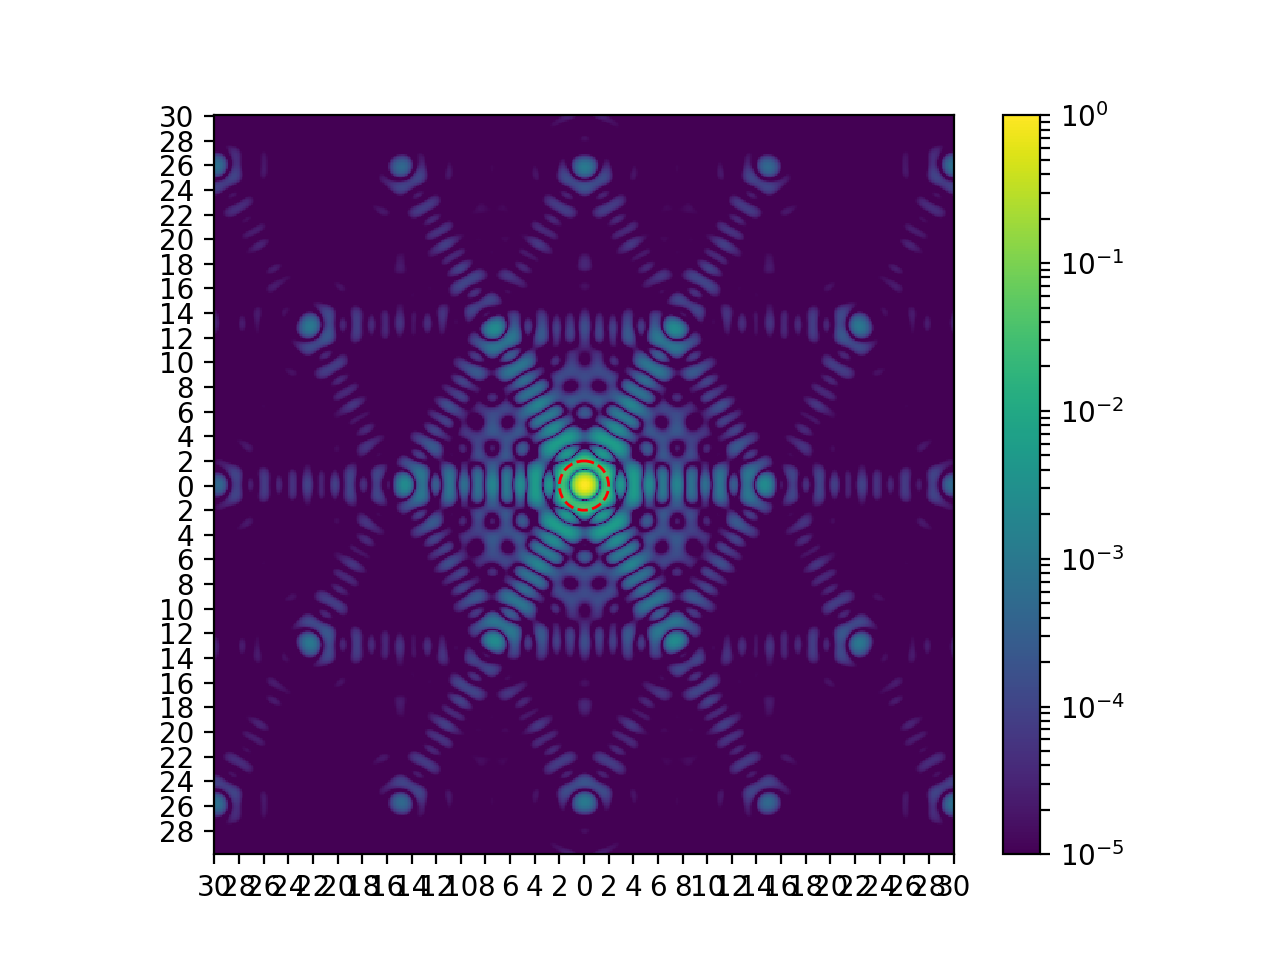

In [45]:
plot_im_ld(PSF/np.max(PSF), lD, 30, log_scale=True, log_min=-5)

<IPython.core.display.Javascript object>


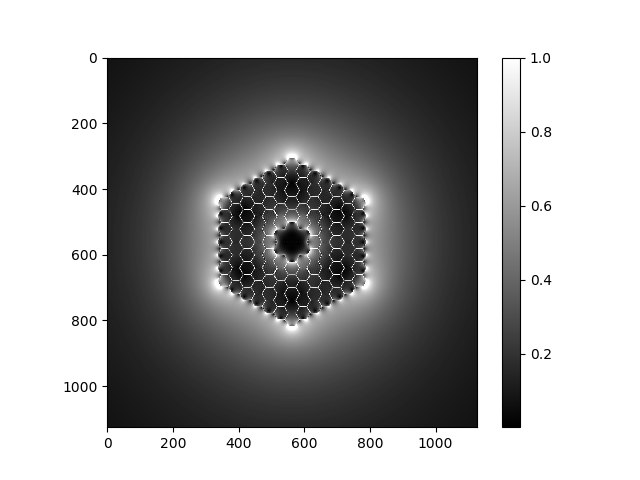

In [6]:
FPM_init = np.exp(1j*2*THETA)
FP_vortex = FP*FPM_init
LP = myifft2(FP_vortex)

plot_im_LP(abs(LP), apRad, 1.2, vmax=1)

<IPython.core.display.Javascript object>


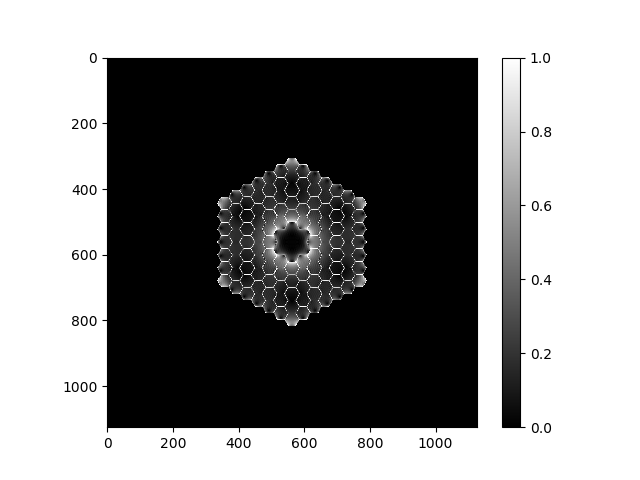

0.3232429210850375


In [7]:
LS = fits.getdata("LUVOIRoptimization/LUVOIRapertureLyotStop.fits")
LS = np.lib.pad(LS, (int(N/2)-apRad, int(N/2)-apRad), 'constant', constant_values=(0,0))

plot_im_LP(abs(LP)*LS, apRad, 1.2, vmax=1)
print(np.sum(abs(LP)*LS)/np.sum(EP*LS))

<IPython.core.display.Javascript object>


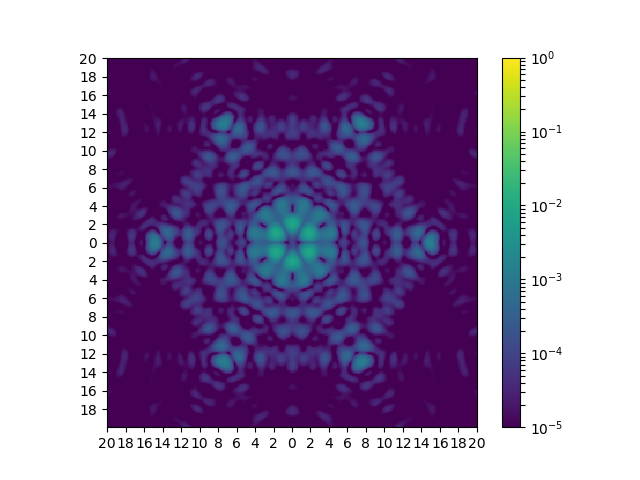

Peak to peak contrast: 0.00953187521242439


In [9]:
PSFvortex = np.abs(myfft2(LP*LS))**2
plot_im_ld(PSFvortex/np.max(PSF), lD, 20, log_scale=True, log_min=-5, n=None)
print("Peak to peak contrast:", np.max(PSFvortex/np.max(PSF)))

## Focal plane mask optimization

<IPython.core.display.Javascript object>


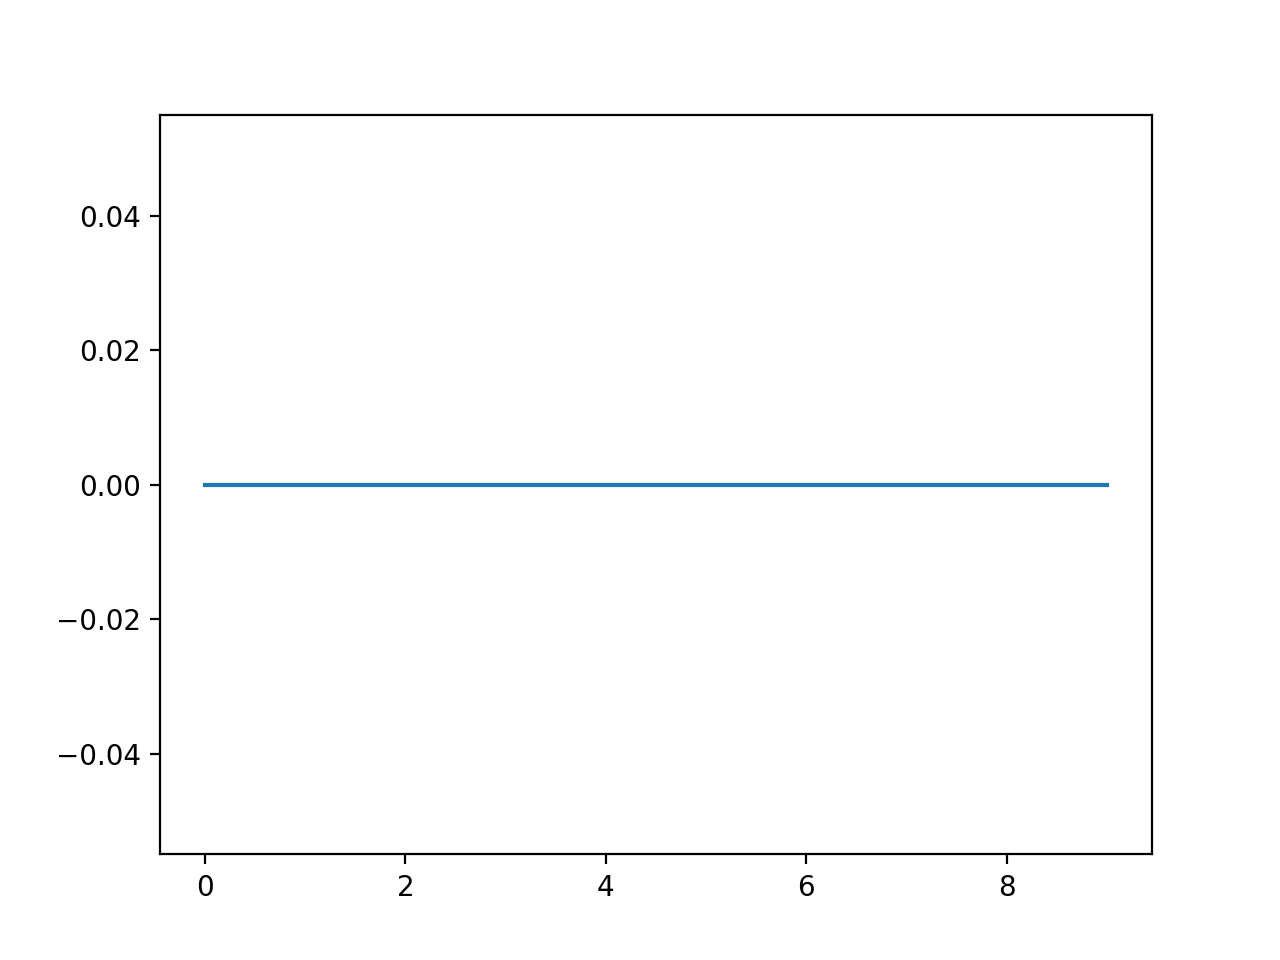

In [39]:
normI = np.max(np.max(abs(myfft2(EP))**2))  # Irradiance normalization

charge = 2
FPM_init = np.exp(1j*charge*THETA)

OPT_REG_FP = np.ones((N,N))

#LS=EP
OPT_REG_LP = LS

max_its = 100
goal_leak = 1e-6
FPM,FPC,its,leak = calcMask(EP, FPM_init, LS, OPT_REG_FP, OPT_REG_LP, 10, goal_leak, ROI=True, ROIval=[2.5,4],lD=lD)



<IPython.core.display.Javascript object>


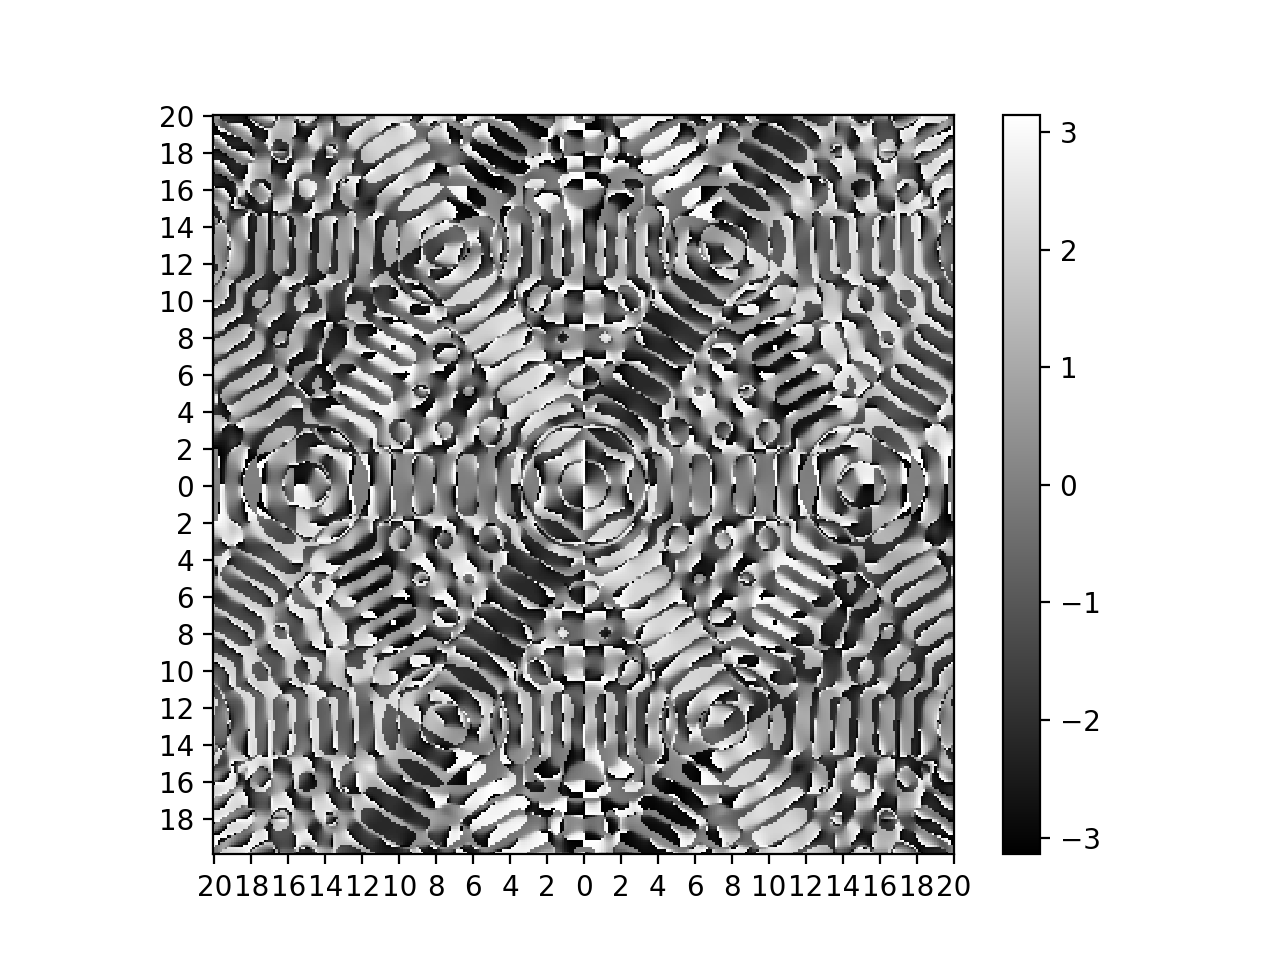

In [44]:
plot_im_ld(np.angle(FPM), lD, 20, color='gray', v_min=-np.pi, v_max=np.pi, n=None)

In [42]:
LPopt = myifft2(FP*FPM)
plot_im_LP((abs(LPopt)), apRad, 1.2, vmax=1)

<IPython.core.display.Javascript object>


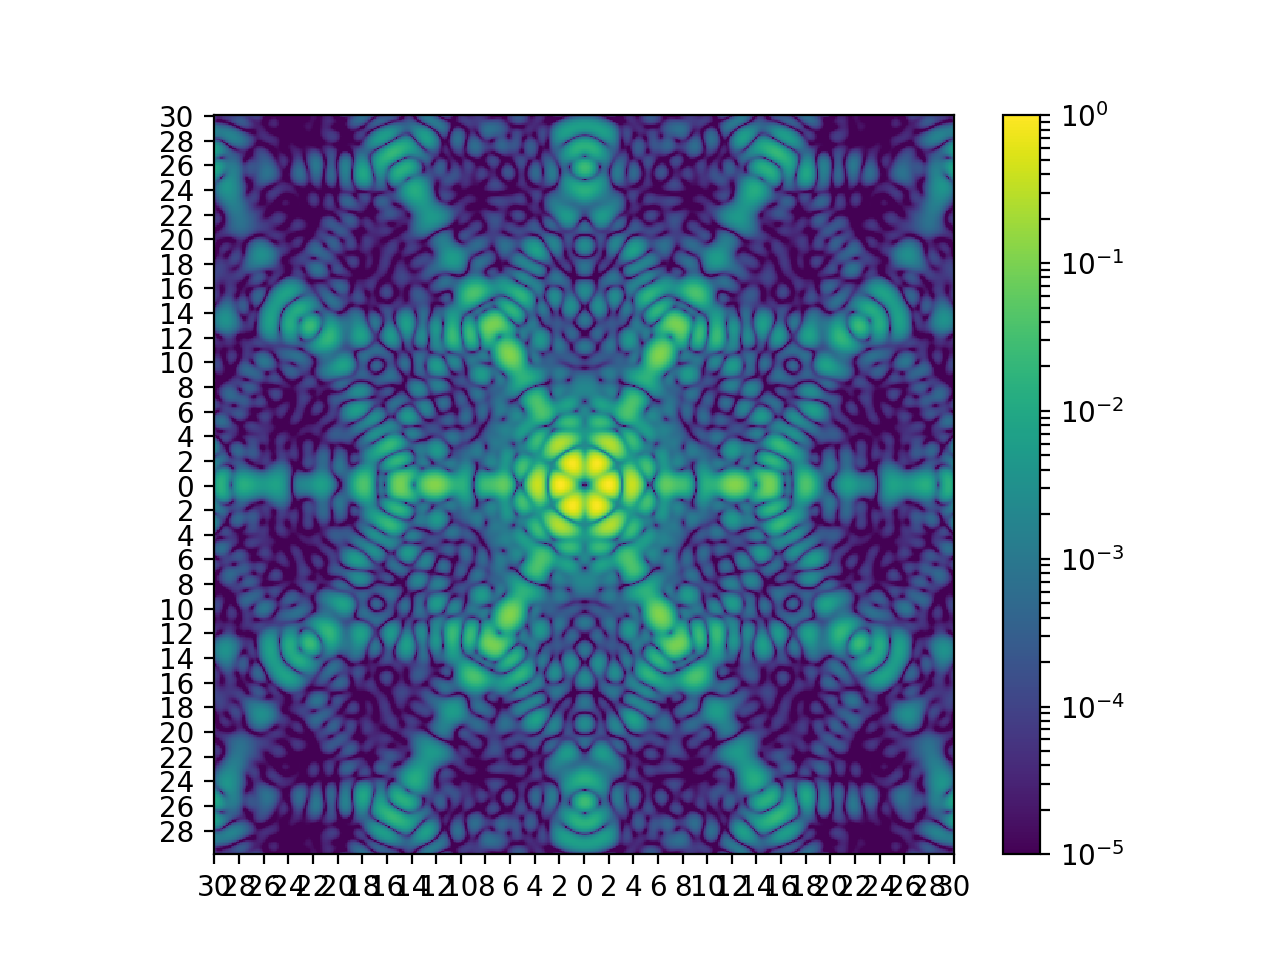

Peak to peak contrast: 8.256302089388966e-05


In [43]:
LPnoise = LPopt# + 1E-4 + np.random.random(size=(N,N))*1E-4
PSFopt = np.abs(myfft2(LPnoise*LS))**2
plot_im_ld(PSFopt/np.max(PSFopt), lD, 30, log_scale=True, log_min=-5, n=None)
print("Peak to peak contrast:", np.max(PSFopt/np.max(PSF)))#

In [13]:
def crop(im, n, N):
    if len(im)>1:
        return [p[int(N/2-n):int(N/2+n),int(N/2-n):int(N/2+n)] for p in im]
    else:
        return im[int(N/2-n):int(N/2+n),int(N/2-n):int(N/2+n)]
#data = crop([EP, PSF, abs(LPopt), PSFopt], 512, 4096)
#data.append(np.angle(FPM))
#hdu = fits.PrimaryHDU(data=np.angle(FPM))
#hdu.header = fits.getheader("LUVOIRoptimization/LUVOIRaperture.fits")
#hdu.writeto("LUVOIRoptimization/LUVOIR_GS_FPMopt.fits")

# Pupil plane phase apodizer 

<IPython.core.display.Javascript object>


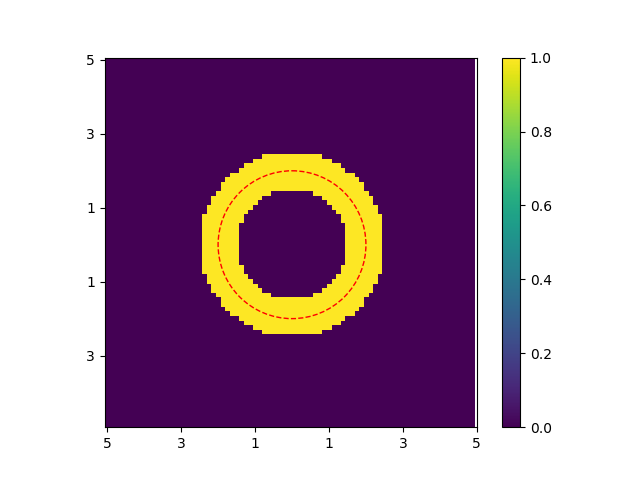

In [6]:
OPT_REG_FP = np.zeros((N,N))
OPT_REG_FP[np.where(RHO<2.5*lD)] = 1
OPT_REG_FP[np.where(RHO<1.5*lD)] = 0
plot_im_ld(OPT_REG_FP, lD, 5)

100%|██████████| 400/400 [1:44:01<00:00, 15.60s/it]


<IPython.core.display.Javascript object>


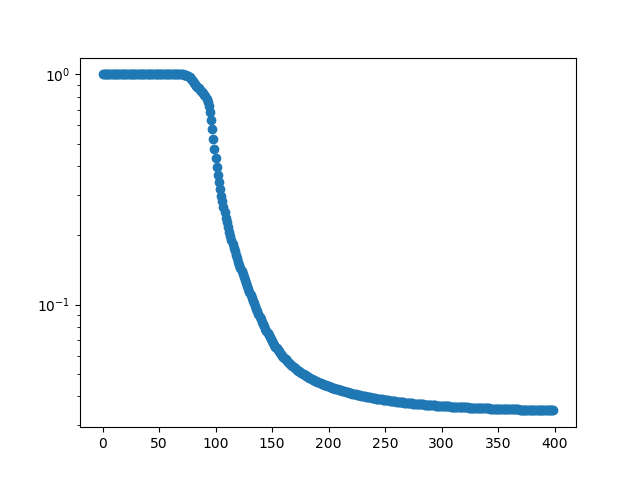

0.0346709665606


In [7]:
optEP= modified_GS_phase(EP, EP, OPT_REG_FP, 400)

<IPython.core.display.Javascript object>


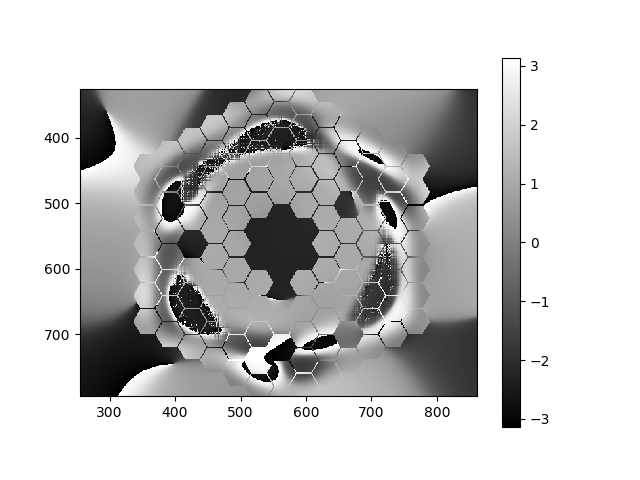

In [9]:
plot_im_LP(np.angle(optEP), apRad, 1.2)

<IPython.core.display.Javascript object>


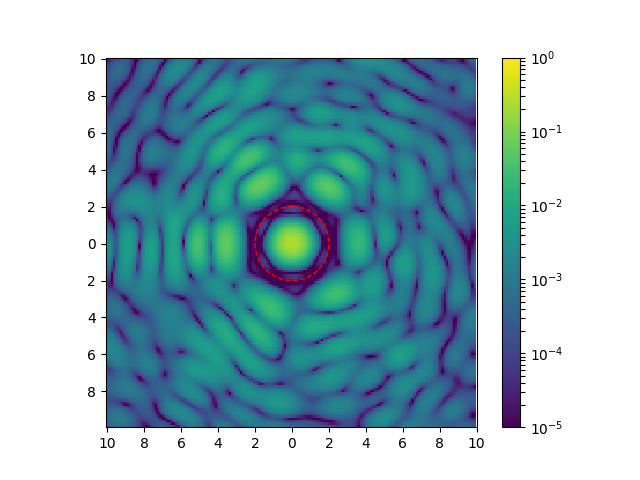

0.00153604225749


In [11]:
PAopt = EP*optEP
PSFapodized = np.abs(myfft2(PAopt))**2
plot_im_ld(PSFapodized/np.max(PSF), lD, 10, log_scale=True, log_min=-5)

print(np.sum(OPT_REG_FP*PSFapodized)/np.sum(OPT_REG_FP*PSF))

In [14]:
data = crop([np.angle(optEP), PSFapodized/np.max(PSF)], 512, 4096)
#data.append(np.angle(FPM))
hdu = fits.PrimaryHDU(data=data)
hdu.header = fits.getheader("LUVOIRoptimization/LUVOIRaperture.fits")
hdu.writeto("LUVOIRoptimization/LUVOIR_MissingSegm_PupilPlaneCoronograph_optimised.fits")

## Dead segments

In [107]:
segments_missing = list(range(7,90))

for i in range(5):
    j = np.random.randint(0, len(segments_missing))
    del segments_missing[j]
segments_missing.extend(range(91,total))

<IPython.core.display.Javascript object>


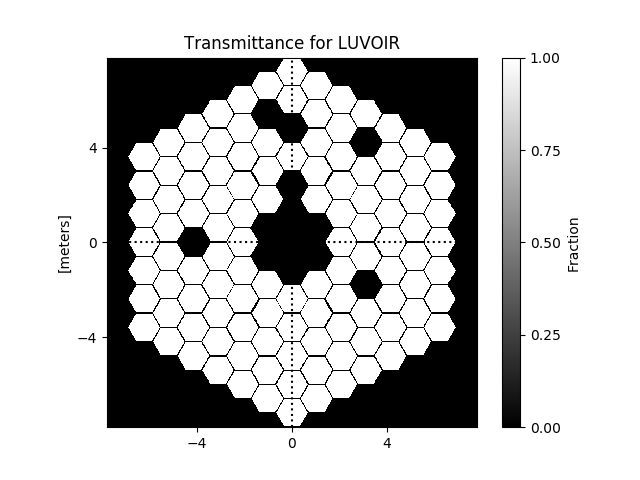

In [108]:
ap2 = poppy.MultiHexagonAperture(name="LUVOIR", rings=6, gap=0.05, center=False, flattoflat=1.15, segmentlist=segments_missing)
ap2.display(npix=1024, colorbar_orientation='vertical')
#ap2.toFITS(outname="LUVOIRapertureLyotStop.fits", what='amplitude', npix=512)

In [109]:
ap2.toFITS(outname="LUVOIRapertureMissingSegm=5.fits", what='amplitude', npix=512)

In [6]:
EPms = fits.getdata("LUVOIRoptimization/LUVOIRapertureMissingSegm=5.fits")
EPms = np.lib.pad(EPms, (int(N/2)-apRad, int(N/2)-apRad), 'constant', constant_values=(0,0))

<IPython.core.display.Javascript object>


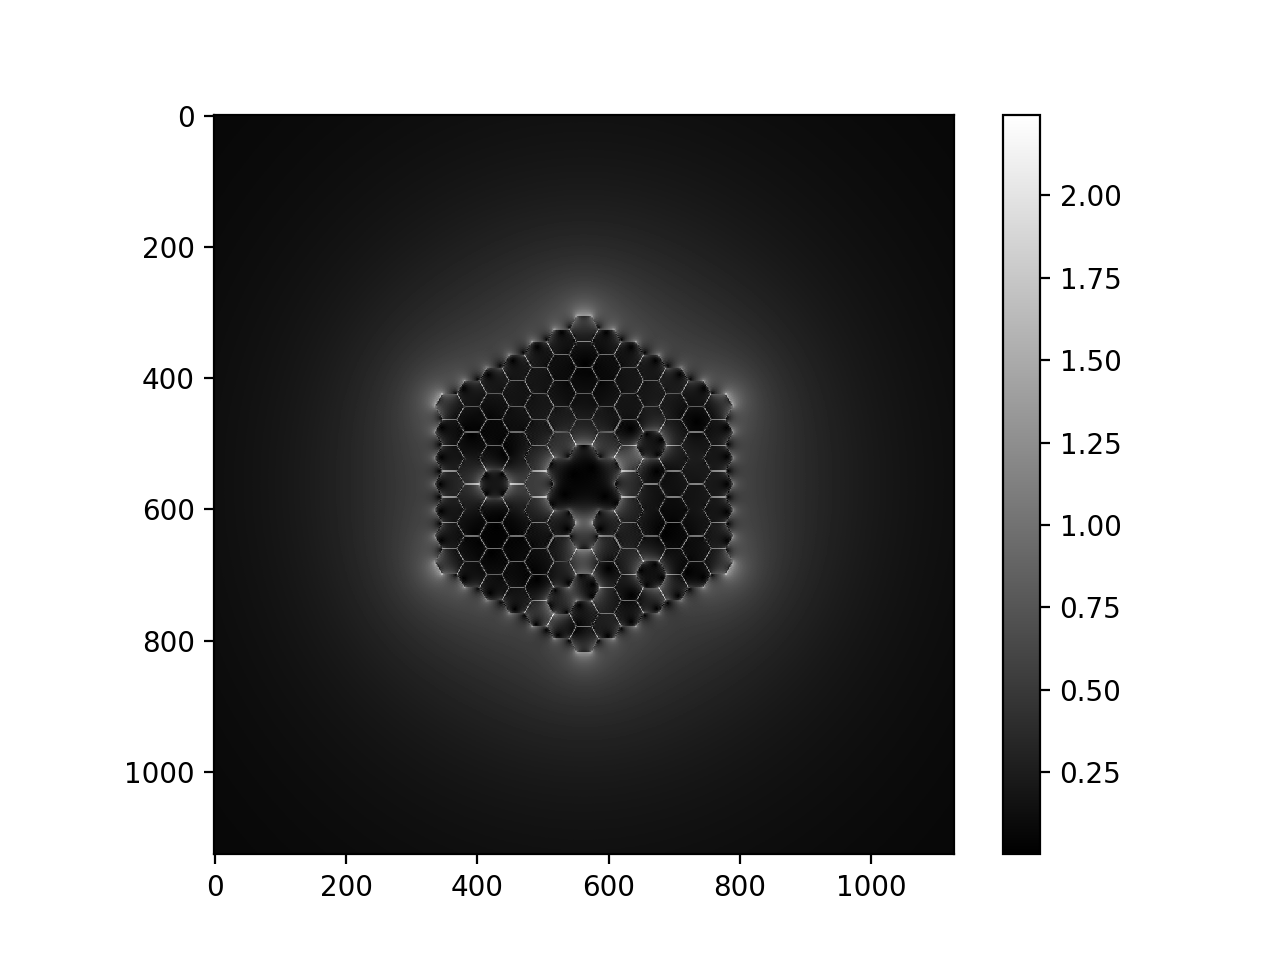

In [7]:
LPms = myifft2(myfft2(EPms)*np.exp(2*1j*THETA))
plot_im_LP(abs(LPms), apRad, 1.2)

<IPython.core.display.Javascript object>


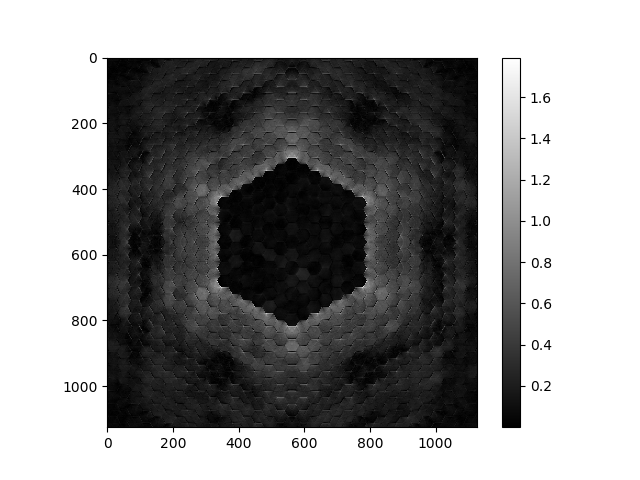

In [115]:
LPmsopt = myifft2(myfft2(EPms)*FPM)
plot_im_LP(abs(LPmsopt), apRad, 1.2)

In [120]:
data = crop([abs(LPms), abs(LPmsopt)], 512, 4096)
#data.append(np.angle(FPM))
hdu = fits.PrimaryHDU(data=data)
hdu.header = fits.getheader("LUVOIRoptimization/LUVOIRaperture.fits")
hdu.writeto("LUVOIRoptimization/LUVOIR_MissingSegm_LP.fits")

<IPython.core.display.Javascript object>


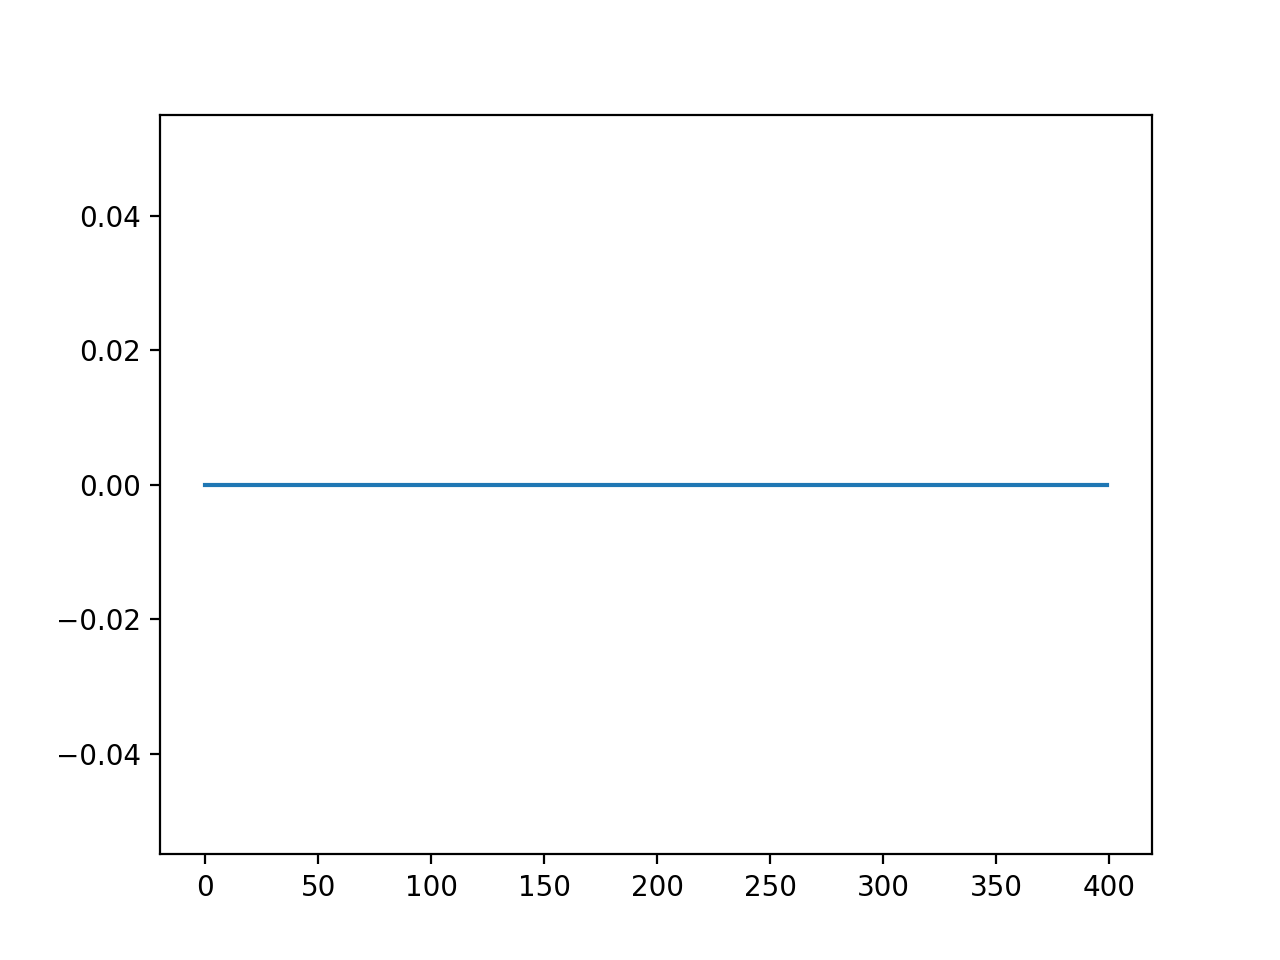

In [9]:
normI = np.max(np.max(abs(myfft2(EPms))**2))  # Irradiance normalization

charge = 2
FPM_init = np.exp(1j*charge*THETA)

OPT_REG_FP = np.ones((N,N))

#LS=EP
OPT_REG_LP = LS

max_its = 400
goal_leak = 1e-6
FPM,FPC,its,leak = calcMask(EPms, FPM_init, LS, OPT_REG_FP, OPT_REG_LP, max_its, goal_leak )

In [ ]:
print('Hello')

In [10]:
hdu = fits.PrimaryHDU(data=np.angle(FPM))
hdu.header = fits.getheader("LUVOIRoptimization/LUVOIRaperture.fits")
hdu.writeto("LUVOIRoptimization/LUVOIR_optFPP.fits")

<IPython.core.display.Javascript object>


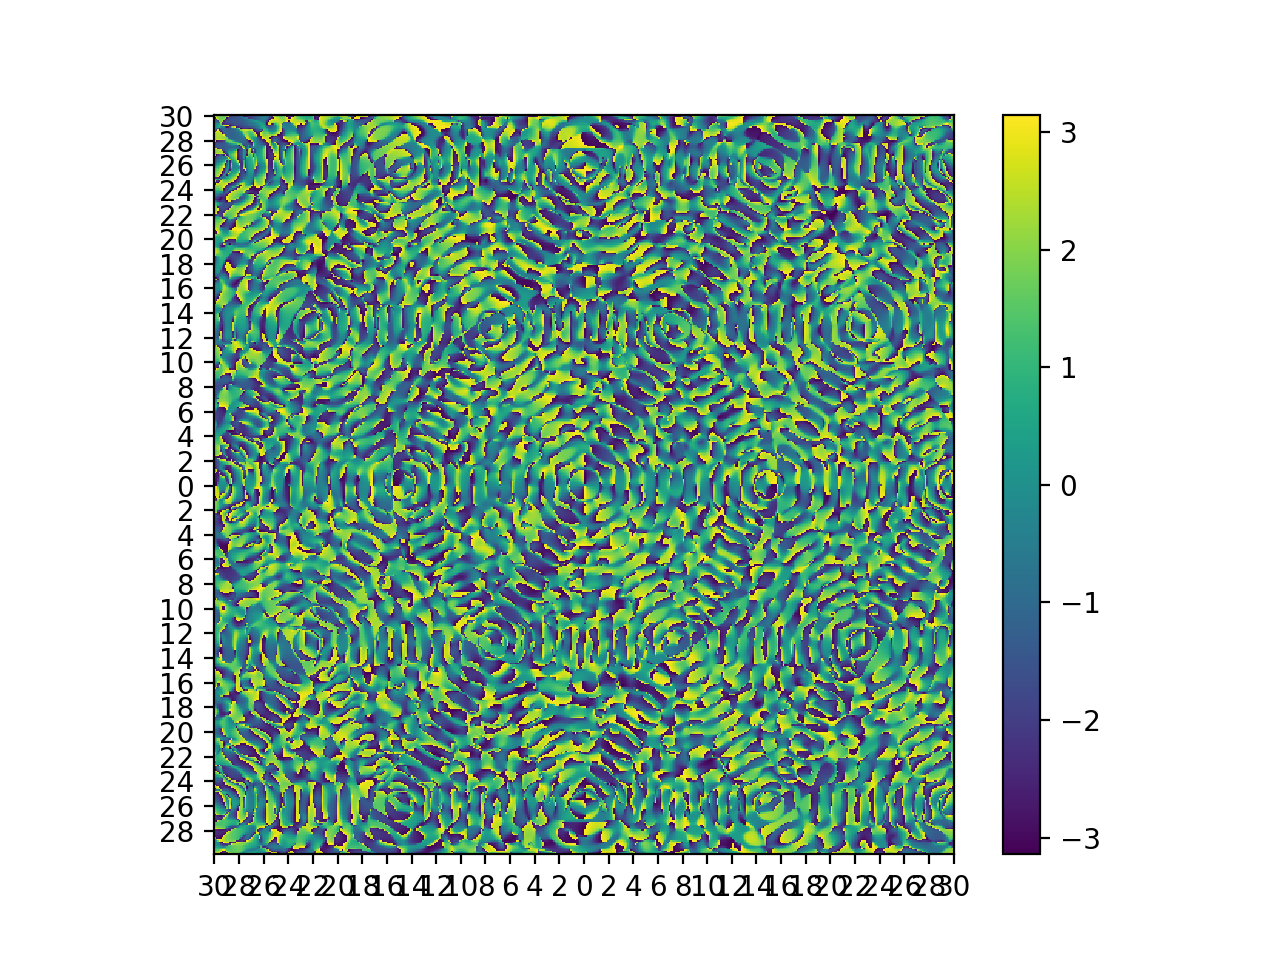

In [16]:
plot_im_ld(np.angle(FPM), lD, 30, n=None, v_min=-np.pi, v_max=np.pi)

<IPython.core.display.Javascript object>


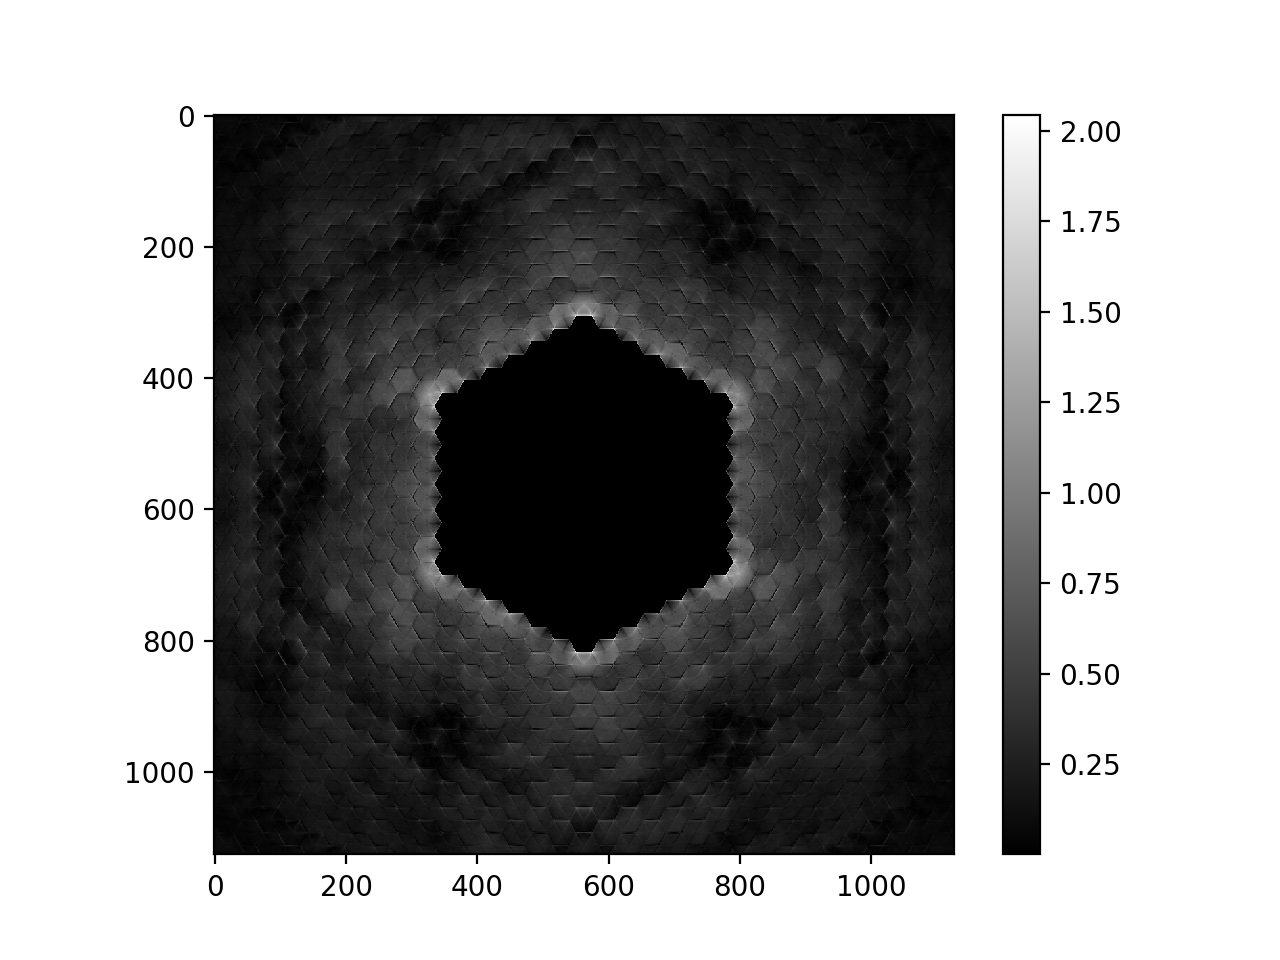

In [11]:
LPms_opt = myifft2(myfft2(EPms)*FPM)
plot_im_LP(abs(LPms_opt), apRad, 1.2)

<IPython.core.display.Javascript object>


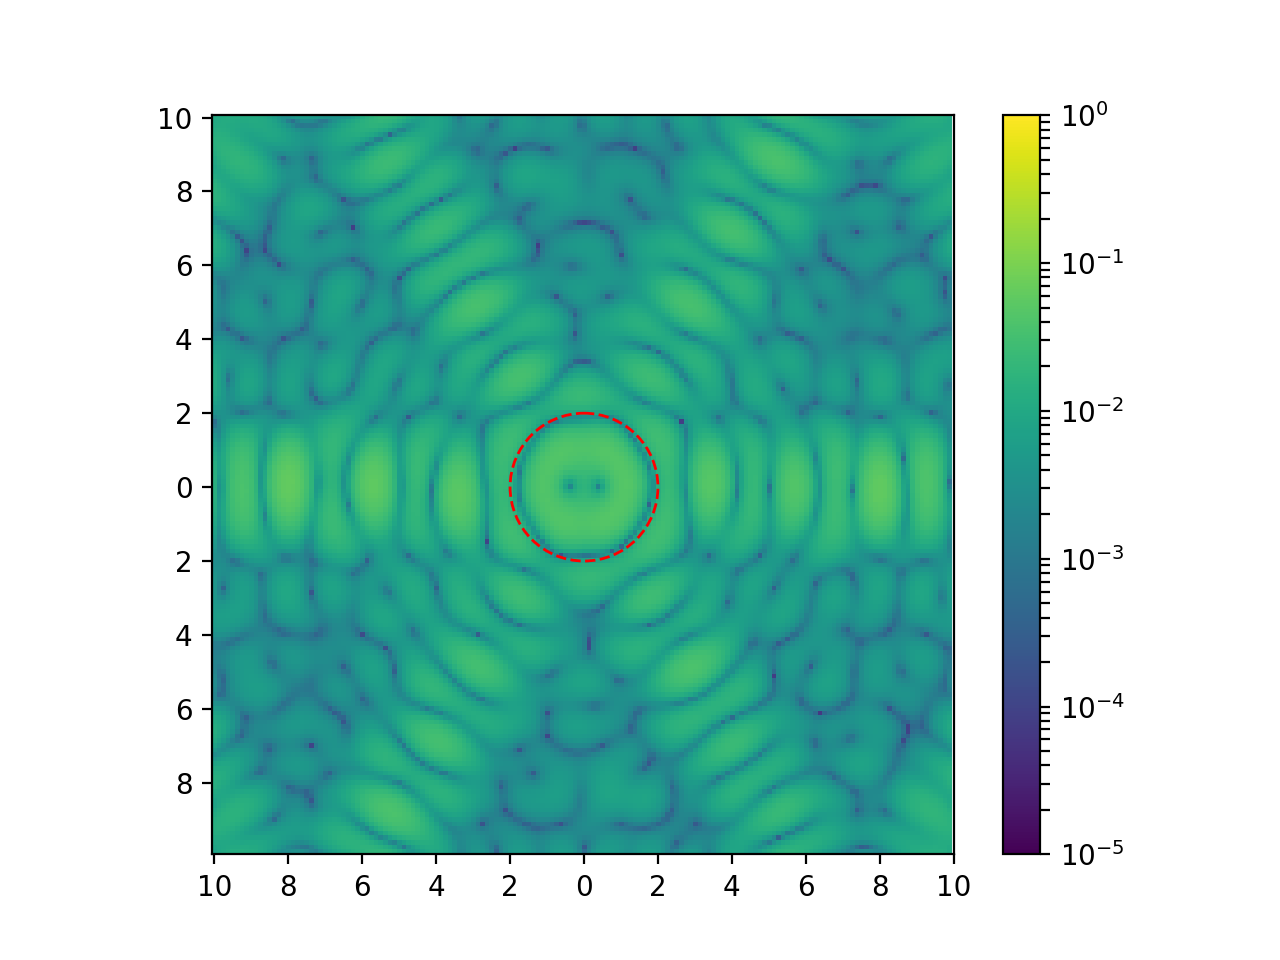

In [26]:
PSFms_opt = np.abs(myfft2(LPms_opt*LS))
plot_im_ld(PSFms_opt, lD, 10, log_scale=True, log_min=-5)

In [28]:
data = crop([abs(LPms_opt), PSFms_opt], 1024, N)
hdu = fits.PrimaryHDU(data=data)
hdu.writeto("LUVOIRoptimization/LUVOIR_MissingSegments_GS_FPMopt.fits")

In [25]:
optEPms= modified_GS_phase(EPms, EP, OPT_REG_FP, 400)


  0%|          | 1/400 [00:06<40:44,  6.13s/it]


KeyboardInterrupt: 